In [5]:
from qiskit import QuantumCircuit, transpile
# from qiskit.providers.aer import QasmSimulator
# from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakeManila, FakeToronto
from qiskit.opflow import I, X, Y, Z, Zero, One, Plus, Minus, PauliTrotterEvolution, CircuitSampler, PauliOp, PauliSumOp, Suzuki
from qiskit.circuit import Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import QDrift, LieTrotter, SuzukiTrotter
from qiskit.visualization import plot_histogram
import qiskit.quantum_info as qi

import numpy as np
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn.preprocessing as skp
from scipy.signal import savgol_filter
import scipy
import os
import sys
import itertools
from numpy.random import Generator, PCG64
from datetime import date
import pathlib
import inspect
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('..')) # qrc_surrogate
sys.path.append(module_path)

from src.data import DataSource
from src.circuits import ising_circuit


# Ising model

In [6]:
nqubits = 2
rseed = 1

h = 1
h_op = 4*(X^X) + (1/2)*(h + 3)*(Z^I) + (1/2)*(h + 3)*(I^Z)
t = 1

h_mat = np.zeros(shape=(2**nqubits, 2**nqubits))

In [7]:
qc =  QuantumCircuit(nqubits)
qubits_system = [*range(nqubits)]

trotterized_op = PauliEvolutionGate(h_op, time=t, synthesis=LieTrotter(reps=1))
qc.append(trotterized_op, qubits_system)

qc = transpile(qc, backend=AerSimulator())
qc.draw()

┌─────────┐┌───────┐
q_0: ┤0        ├┤ Rz(4) ├
     │  Rxx(8) │├───────┤
q_1: ┤1        ├┤ Rz(4) ├
     └─────────┘└───────┘

In [8]:
qc =  QuantumCircuit(nqubits)
qubits_system = [*range(nqubits)]

xmat = np.array([[0, 1], [1, 0]])
ymat = np.array([[0, 1], [1, 0]])
zmat = np.array([[1, 0], [0, -1]])

h_mat = np.kron(xmat, xmat)

h_unitary = scipy.linalg.expm(-1j * t * h_mat)
qc.unitary(h_unitary, qubits_system, label='H')

# qc = transpile(qc, backend=AerSimulator(), basis_gates=['cx', 'id', 'rxx', 'x', 'sx', 'rz', 'reset'])
qc = transpile(qc, backend=AerSimulator(), basis_gates=['rxx', 'rz', 'u'])
qc.draw()

/opt/homebrew/anaconda3/envs/envrl/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/anaconda3/envs/envrl/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


global phase: 5.5297
            ┌──────────────┐       ┌───────────┐      ┌────────────────┐     »
q_0: ───────┤ U(π,π/2,π/2) ├───────┤0          ├──────┤ U(π/2,π/2,π/2) ├─────»
     ┌──────┴──────────────┴──────┐│  Rxx(π/2) │┌─────┴────────────────┴────┐»
q_1: ┤ U(1.6022,-0.031449,0.7849) ├┤1          ├┤ U(2.3576,-0.4262,-2.7154) ├»
     └────────────────────────────┘└───────────┘└───────────────────────────┘»
«     ┌───────────┐     ┌─────────────────┐      
«q_0: ┤0          ├─────┤ U(π/2,-π/2,π/2) ├──────
«     │  Rxx(π/2) │┌────┴─────────────────┴─────┐
«q_1: ┤1          ├┤ U(1.6022,0.7849,-0.031449) ├
«     └───────────┘└────────────────────────────┘

# Critical parameter

- Many-body localization in spin chains with long-range transverse interactions: Scaling of critical disorder with system size

In [9]:
j0 = 1
n = 5 # nqubits
a = 1 # long range limit, < 3/2

for a in [0.1, .5, 1, 1.25, 1.4]:
    if a <= 1 and a > 0:
        wc = (1.37 * j0 / ( (4/3) - a)) * (n**((4/3) - a)) * np.log(n) # 0 < a < 1
        print(f'a = {a:.2f}, wc = {wc:.2f}')
    elif a > 1 and a < 3/2:
        wc = (j0/(1 - (2 * a / 3))) * n**(1 - (2 * a / 3)) * np.log(n)**(2/3)  # 1 < a < 3/2
        print(f'a = {a:.2f}, wc = {wc:.2f}')
    else:
        raise ValueError(f'a = {a}')

a = 0.10, wc = 13.01
a = 0.50, wc = 10.12
a = 1.00, wc = 11.31
a = 1.25, wc = 10.78
a = 1.40, wc = 22.93


# entropy

In [10]:
def von_neumann_entropy(dm, subsystem=[0], base_e=True):
    subdm = qi.partial_trace(dm, qargs=subsystem)
    mat = subdm.data
    if base_e:
        return -1 * np.trace(
            np.matmul(mat, np.log(mat))
        )
    else:
        return -1 * np.trace(
            np.matmul(mat, np.log2(mat))
        )

In [11]:
nqubits = 2
shots = 10000
subsystem = [0]
qubits_system = [*range(nqubits)]
sim = AerSimulator(method='statevector') # density_matrix

qc = QuantumCircuit(nqubits)
qc.h(0)
qc.cnot(0, 1)

sv = qi.Statevector.from_label('0'*nqubits)
sv = sv.evolve(qc)
subsv = qi.partial_trace(sv, qargs=subsystem)
entropy = qi.entropy(subsv)

print(entropy)


sim = AerSimulator(method='density_matrix') # statevector density_matrix

qc = QuantumCircuit(nqubits)
qc.h(0)
qc.cnot(0, 1)

sv = qi.Statevector.from_label('0'*nqubits)
sv = qi.DensityMatrix(sv.data)
sv = sv.evolve(qc)
subsv = qi.partial_trace(sv, qargs=subsystem)
entropy = qi.entropy(subsv)

print(entropy)


1.0
1.0


# Rxx Entropy

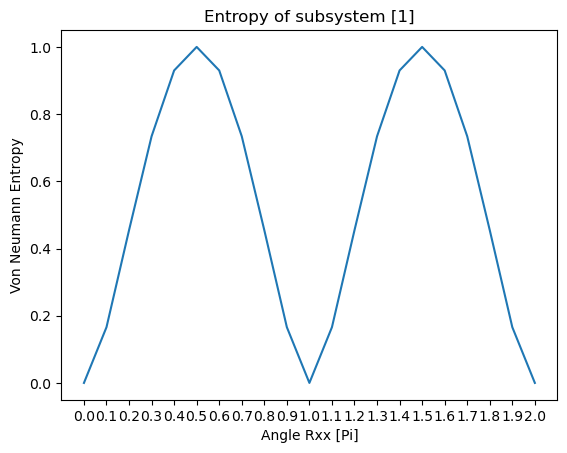

In [12]:
nqubits = 2
shots = 10000
qubits_system = [*range(nqubits)]
subsystem = [1]
sim = AerSimulator(method='statevector') # density_matrix

counts_list = []
entropy_list = []

h = .1
w = 10

js = np.arange(0, 2.1, .1)
for j in js:
    t = 1

    qc = QuantumCircuit(nqubits)
    qc.rxx(theta=(j * t * np.pi), qubit1=0, qubit2=1)

    # qc.rz(phi=1/2 * t * (h + w), qubit=0)
    # qc.rz(phi=1/2 * t * (h + w), qubit=1)
    # qc.rz(phi=1/2 * t * (h + w) * np.pi, qubit=0)
    # qc.rz(phi=1/2 * t * (h + w) * np.pi, qubit=1)

    # qc.measure(qubits_system, qubits_system)
    # qc = transpile(qc, backend=sim, basis_gates=['rxx', 'rz', 'u'])
    # job = sim.run(qc, shots=shots)
    # result = job.result()
    # counts = result.get_counts()

    sv = qi.Statevector.from_label('0'*nqubits)
    sv = qi.DensityMatrix(sv.data)
    sv = sv.evolve(qc)
    subsv = qi.partial_trace(sv, qargs=subsystem)
    entropy_list.append(qi.entropy(subsv))
    counts = sv.sample_counts(shots=shots)


    counts_list.append(counts)
    # qc.draw()

colors = list(sns.color_palette())
colors += colors
# plot_histogram(counts_list, legend=[str(round(j, 1)) for j in js], color=colors[:len(js)], bar_labels=False)

plt.figure()
plt.plot(js, entropy_list)
plt.xticks(js)
plt.xlabel('Angle Rxx [Pi]')
plt.ylabel('Von Neumann Entropy')
plt.title(f'Entropy of subsystem {subsystem}')
plt.show()

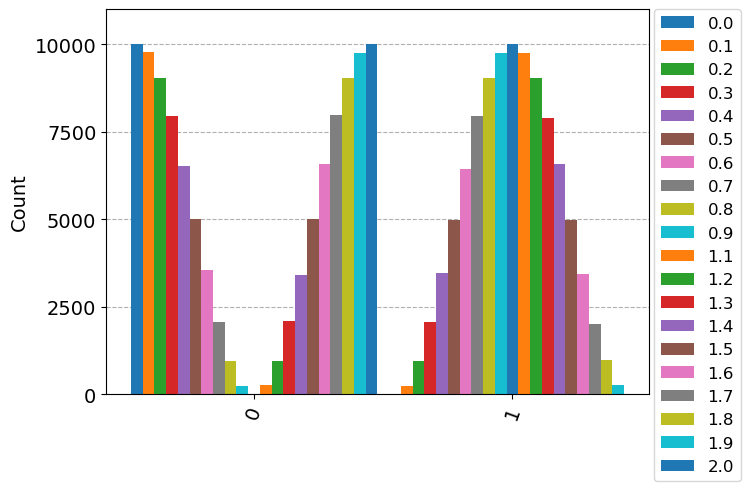

In [13]:
nqubits = 1
qubits_system = [*range(nqubits)]
sim = AerSimulator()

counts_list = []
for j in js:
    t = 1

    qc =  QuantumCircuit(nqubits, nqubits)
    qc.rx(theta=(j * t * np.pi), qubit=0)
    # qc.rz(phi=1/2 * t * (h + w) * np.pi, qubit=1)
    # qc.rz(phi=1/2 * t * (h + w) * np.pi, qubit=2)
    qc.measure(qubits_system, qubits_system)
    qc = transpile(qc, backend=sim, basis_gates=['rxx', 'rx', 'rz', 'u'])
    job = sim.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts()
    counts_list.append(counts)
    # qc.draw()

colors = list(sns.color_palette())
colors += colors
plot_histogram(counts_list, legend=[str(round(j, 1)) for j in js], color=colors[:len(js)], bar_labels=False)


# Fully connected ising

In [14]:
def ising_circuit(nqubits, rseed=0):
    """
    https://arxiv.org/pdf/2103.05348.pdf
    J in (-jmax/2, jmax/2)
    D in (-wmax, wmax)
    best: J=1, h=0.1, W=.5
    """
    qc =  QuantumCircuit(nqubits)
    rng = Generator(PCG64(seed=rseed))
    for j in range(nqubits):
        for i in range(j+1, nqubits):
            qc.rxx(theta=(rng.random() * jmax - (jmax/2)) * t, qubit1=i, qubit2=j)
        qc.rz(phi=1/2 * t * (h + (rng.random() * 2 * wmax - wmax)), qubit=j)
    return qc
